In [1]:
# utility libraries
from datetime import timedelta
import math

# storing and anaysis
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px

In [2]:
# dealing with geographic data
import geopandas as gpd
from geopandas.tools import geocode

# implicitly registered datetime converter for a matplotlib plotting method
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
# offline plotly
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

In [4]:
df = pd.read_csv('cdc_zika.csv')
df.head(10)

report_date                location location_type  \
0  2016-03-19  Argentina-Buenos_Aires      province   
1  2016-03-19  Argentina-Buenos_Aires      province   
2  2016-03-19  Argentina-Buenos_Aires      province   
3  2016-03-19  Argentina-Buenos_Aires      province   
4  2016-03-19  Argentina-Buenos_Aires      province   
5  2016-03-19  Argentina-Buenos_Aires      province   
6  2016-03-19          Argentina-CABA      province   
7  2016-03-19          Argentina-CABA      province   
8  2016-03-19          Argentina-CABA      province   
9  2016-03-19          Argentina-CABA      province   

                            data_field data_field_code  time_period  \
0     cumulative_confirmed_local_cases          AR0001          NaN   
1      cumulative_probable_local_cases          AR0002          NaN   
2  cumulative_confirmed_imported_cases          AR0003          NaN   
3   cumulative_probable_imported_cases          AR0004          NaN   
4         cumulative_cases_under_study          AR0005          NaN   
5           cumulative_cases_discarded          AR0006          NaN   
6     cumulative_confirmed_local_cases          AR0001          NaN   
7      cumulative_probable_local_cases          AR0002          NaN   
8  cumulative_confirmed_imported_cases          AR0003          NaN   
9   cumulative_probable_imported_cases          AR0004          NaN   

   time_period_type value   unit  
0               NaN     0  cases  
1               NaN     0  cases  
2               NaN     2  cases  
3               NaN     1  cases  
4               NaN   127  cases  
5               NaN     0  cases  
6               NaN     0  cases  
7               NaN     0  cases  
8               NaN     9  cases  
9               NaN     0  cases

In [5]:
df.drop('time_period', inplace=True, axis=1)
df.drop('time_period_type', inplace=True, axis=1)

In [6]:
df.dropna(inplace=True)

In [7]:
df['value']=pd.to_numeric(df['value'], errors='coerce')
df.dropna(inplace=True)
df = df.astype({"value":int})
df['report_date'] = pd.to_datetime(df['report_date'], errors='coerce')

In [8]:
df.dropna(inplace=True)

In [9]:
# Get names of indexes for which column value has value 0
indexNames = df[ df['value'] == 0 ].index
# # Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)

In [10]:
df[['Country','State/Province','City/Mun']] = df.location.str.split('-',n=2,expand=True)
df.drop(columns=['location'], inplace=True)

In [11]:
#Data cleaning for merge
df['Country']=df['Country'].replace('Dominican_Republic','Dominican Republic')
df['Country']=df['Country'].replace('El_Salvador','El Salvador')
df['Country']=df['Country'].replace('Puerto_Rico','Puerto Rico')
df['Country']=df['Country'].replace('United_States','United States')
df['Country']=df['Country'].replace('United_States_Virgin_Islands','U.S. Virgin Islands')

In [12]:
df_country = df.groupby(['Country']).sum()[['value']].apply(lambda x: x.sort_values(ascending=False)).reset_index()
df_country.rename(columns={'value':'Cases'}).head(5)

Country    Cases
0       Brazil  2041135
1     Colombia  1536401
2      Sudeste   366093
3  El Salvador   354031
4     Nordeste   337035

In [13]:
world_map = pd.read_csv('countries.csv')


In [14]:
world_map.head()

country   latitude  longitude                  name
0      AD  42.546245   1.601554               Andorra
1      AE  23.424076  53.847818  United Arab Emirates
2      AF  33.939110  67.709953           Afghanistan
3      AG  17.060816 -61.796428   Antigua and Barbuda
4      AI  18.220554 -63.068615              Anguilla

In [15]:
#Merge WorldMap with data grouped by country
zika_map = world_map.merge(df_country, left_on='name', right_on='Country')
zika_map = zika_map.sort_values('value', ascending=False)
zika_map['text'] = zika_map['name'] + '<br>Cases ' + (zika_map['value']).astype(str)

In [16]:
zika_map.head()

country   latitude  longitude                name             Country  \
1       BR -14.235004 -51.925280              Brazil              Brazil   
2       CO   4.570868 -74.297333            Colombia            Colombia   
11      SV  13.794185 -88.896530         El Salvador         El Salvador   
3       DO  18.735693 -70.162651  Dominican Republic  Dominican Republic   
0       AR -38.416097 -63.616672           Argentina           Argentina   

      value                               text  
1   2041135            Brazil<br>Cases 2041135  
2   1536401          Colombia<br>Cases 1536401  
11   354031        El Salvador<br>Cases 354031  
3     94983  Dominican Republic<br>Cases 94983  
0     21826           Argentina<br>Cases 21826

In [17]:
import plotly.graph_objects as go
%matplotlib inline

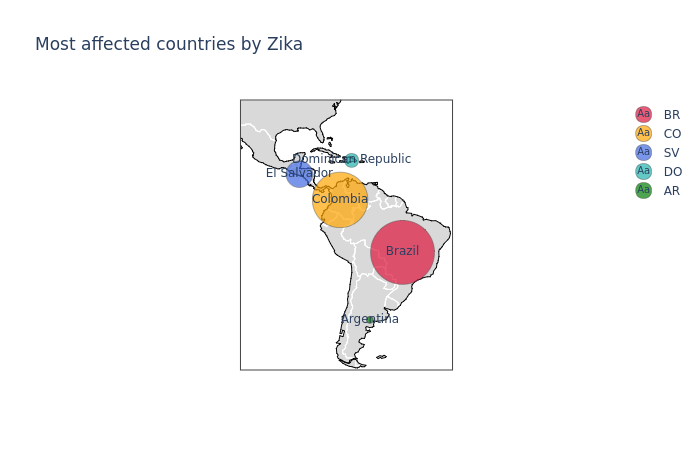

In [18]:
## Bubble Map with go.Scattergeo
countries = ['BR','CO','SV','DO','AR']
colors = ["crimson","orange","royalblue","lightseagreen","green"]
cities = []
scale = 1000
loc = ['Brazil','Colombia','El Salvador','Dominican Republic','Argentina']
fig = go.Figure()

for i in range(len(countries)):
    ct = countries[i]
    df_sub = zika_map[zika_map['country'] == ct]
    fig.add_trace(go.Scattergeo(
        locations = np.array(loc[i]),
        locationmode='country names',
        # z = df_sub['Country'],
        lon = df_sub['longitude'],
        lat = df_sub['latitude'],
        text = df_sub['text'],
        marker = dict(
            size = df_sub['value']/scale,
            color = colors[i],
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode = 'area'
        ),
        name = ct))

for i in range(len(countries)):
    ct = countries[i]
    df_sub = zika_map[zika_map['country'] == ct]
    fig['data'][i].update(mode='markers+text', textposition='middle center',text=df_sub['Country'])


fig.update_layout(
        title_text = 'Most affected countries by Zika',
        showlegend = True,
        geo = go.layout.Geo(
            scope = "world",
            landcolor = 'rgb(217, 217, 217)',
            showframe = True,
            showcoastlines = True,
            showcountries = True,
            countrycolor = "white" ,
            coastlinecolor = "black",
            # projection_type = 'mercator',
            lonaxis_range= [ -34, -110 ],
            lataxis_range= [ 40, -56 ],
            # bgcolor = 'rgba(0, 0, 0, 0.0)',
        ),
        
    )
fig.show("png")

In [19]:
fig.write_image("countries.png")

In [20]:
#Subset for Brazil
df_br=df[df['Country']=="Brazil"]

In [21]:
#groupby by states
df_loc = df_br.groupby(['State/Province']).sum()[['value']].apply(lambda x: x.sort_values(ascending=False)).reset_index()
df_loc['State/Province']=df_loc['State/Province'].replace('([_])',' ',regex=True)
df_loc.rename(columns={'value':'Cases'}).head(5)

State/Province   Cases
0           Bahia  292281
1  Rio de Janeiro  266263
2     Mato Grosso  131318
3    Minas Gerais   76628
4      Pernambuco   48699

In [22]:
#reading Geodata
brazil_map = gpd.read_file('brazil-states.geojson')

In [23]:
brazil_map.head()

id      name sigla regiao_id codigo_ibg  cartodb_id  \
0   1      Acre    AC         3         12           1   
1   2   Alagoas    AL         4         27           2   
2   3  Amazonas    AM         3         13           3   
3   4     Amapá    AP         3         16           4   
4   5     Bahia    BA         4         29           5   

                  created_at                 updated_at  \
0  2015-02-09T16:46:01+00:00  2015-02-09T16:46:01+00:00   
1  2015-02-09T16:46:01+00:00  2015-02-09T16:46:01+00:00   
2  2015-02-09T16:46:01+00:00  2015-02-09T16:46:01+00:00   
3  2015-02-09T16:46:01+00:00  2015-02-09T16:46:01+00:00   
4  2015-02-09T16:46:01+00:00  2015-02-09T16:46:01+00:00   

                                            geometry  
0  MULTIPOLYGON (((-73.60818 -7.20194, -72.86963 ...  
1  MULTIPOLYGON (((-35.46516 -8.82549, -35.46626 ...  
2  MULTIPOLYGON (((-67.32553 2.03012, -67.32234 2...  
3  MULTIPOLYGON (((-51.18168 4.00889, -51.17900 3...  
4  MULTIPOLYGON (((-39.28820 -8.56290, -39.28229 ...

In [24]:
#Data cleaning for merge with geodata
df_loc['State/Province']=df_loc['State/Province'].replace('Amapa','Amapá')
df_loc['State/Province']=df_loc['State/Province'].replace('Ceara','Ceará')
df_loc['State/Province']=df_loc['State/Province'].replace('Espirito Santo','Espírito Santo')
df_loc['State/Province']=df_loc['State/Province'].replace('Goias','Goiás')
df_loc['State/Province']=df_loc['State/Province'].replace('Maranhao','Maranhão')
df_loc['State/Province']=df_loc['State/Province'].replace('Para','Pará')
df_loc['State/Province']=df_loc['State/Province'].replace('Paraiba','Paraíba')
df_loc['State/Province']=df_loc['State/Province'].replace('Piaui','Piauí')
df_loc['State/Province']=df_loc['State/Province'].replace('Parana','Paraná')
df_loc['State/Province']=df_loc['State/Province'].replace('Rondonia','Rondônia')
df_loc['State/Province']=df_loc['State/Province'].replace('Sao Paulo','São Paulo')



In [25]:
#Merge Brazil data with geo
zika_br = brazil_map.merge(df_loc, left_on='name', right_on='State/Province')
zika_br = zika_br.sort_values('value', ascending=False)
zika_br['text'] = zika_br['name'] + '<br>Cases ' + (zika_br['value']).astype(str)

In [26]:
zika_br.head()

id            name sigla regiao_id codigo_ibg  cartodb_id  \
4    5           Bahia    BA         4         29           5   
17  19  Rio de Janeiro    RJ         2         33          19   
11  13     Mato Grosso    MT         5         51          13   
9   11    Minas Gerais    MG         2         31          11   
14  16      Pernambuco    PE         4         26          16   

                   created_at                 updated_at  \
4   2015-02-09T16:46:01+00:00  2015-02-09T16:46:01+00:00   
17  2015-02-09T16:46:01+00:00  2015-02-09T16:46:01+00:00   
11  2015-02-09T16:46:01+00:00  2015-02-09T16:46:01+00:00   
9   2015-02-09T16:46:01+00:00  2015-02-09T16:46:01+00:00   
14  2015-02-09T16:46:01+00:00  2015-02-09T16:46:01+00:00   

                                             geometry  State/Province   value  \
4   MULTIPOLYGON (((-39.28820 -8.56290, -39.28229 ...           Bahia  292281   
17  MULTIPOLYGON (((-44.51273 -23.29293, -44.51640...  Rio de Janeiro  266263   
11  MULTIPOLYGON (((-60.36083 -13.29932, -60.36033...     Mato Grosso  131318   
9   MULTIPOLYGON (((-44.20886 -14.24413, -44.20871...    Minas Gerais   76628   
14  MULTIPOLYGON (((-37.17654 -7.30917, -37.16811 ...      Pernambuco   48699   

                              text  
4            Bahia<br>Cases 292281  
17  Rio de Janeiro<br>Cases 266263  
11     Mato Grosso<br>Cases 131318  
9      Minas Gerais<br>Cases 76628  
14       Pernambuco<br>Cases 48699

In [27]:
#Get centroid for every state
zika_br["x"] = zika_br.centroid.x
zika_br["y"] = zika_br.centroid.y

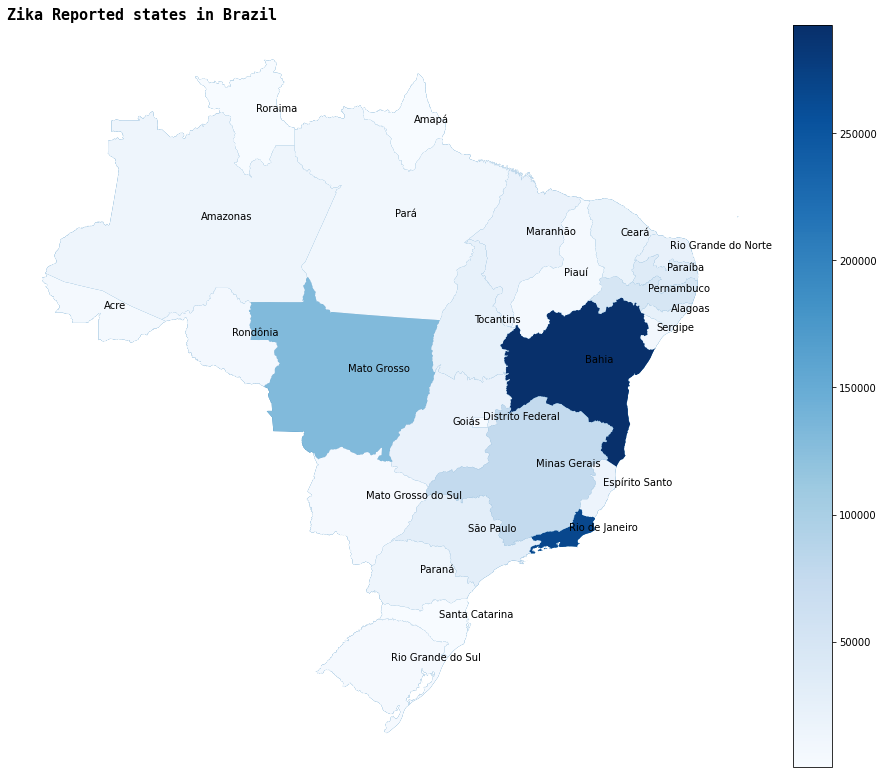

In [28]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

brazil_map.plot(ax=ax)
zika_br.plot(column='value', ax=ax, legend=True, cax=cax, cmap='Blues')


for x, y, label in zip(zika_br.x, zika_br.y, zika_br.name):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

ax.set_title('Zika Reported states in Brazil', loc='left', fontdict={'fontsize':15, 
                                            'fontfamily':'monospace', 
                                            'fontweight': 'bold',
                                            'color':'black'})


ax.set_axis_off()


In [29]:
fig.savefig('BR.png')

In [30]:
# Time series

In [31]:
#Monthly cases
zika_time = df.groupby(['report_date']).sum()[['value']].reset_index()
zika_time=zika_time.set_index('report_date')
zika_time = zika_time.resample('M').sum().reset_index()

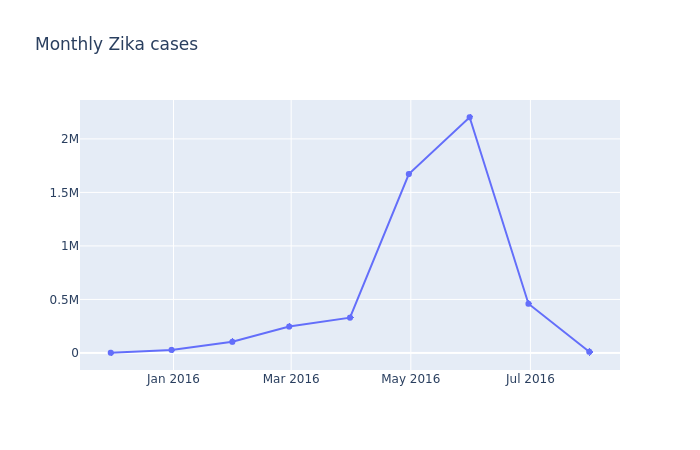

In [32]:
fig = go.Figure([go.Scatter(x=zika_time['report_date'], y=zika_time['value'])])
fig.update_layout(
        title_text = 'Monthly Zika cases')
fig.show("png")

In [33]:
fig.write_image("monthly.png")